---
---

# Recognizing Hand-Written Digits with Neural Networks

---
---

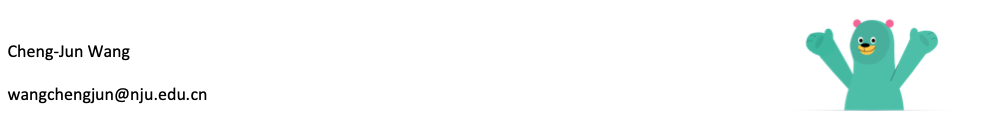




## Recognizing Hand-Written Digits Using Numpy

<div>
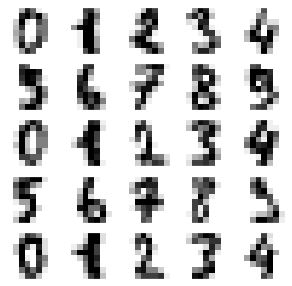
</div>

**Each image has 8*8 = 64 pixels**



- input = 64
    - [0, 0, 1, 0, ..., 0]
- batch size = 100
- hidden neurons = 50
- output = 10
- using relu activation function

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits



In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import sys
from collections import defaultdict
from sklearn import datasets

# load data
digits = datasets.load_digits()


In [44]:
# prepare training sets
N, D_in, H, D_out = 100, 64,  50, 10 # batch size, input, hidden, output dimension
k = 0.9 # the fraction traning data
learning_rate = 1e-6 # 1e-1
L = len(digits.data)
l = int(L*k)
print(L, l)

1797 1617


In [46]:
Batches = {}
M = 200 # number of batches
for j in range(M):
    index=list(np.random.randint(l, size=N)) # randomly sample N data points
    y = np.zeros((N, 10))
    y[np.arange(N), list(digits.target[index])] = 1
    x=digits.data[index]
    Batches[j]=[x,y]

In [40]:
# softmax
def softmax(x):
    e_x = np.exp(x - np.max(x)) # to avoid inf
    return e_x / e_x.sum(axis=0)

def softmaxByRow(x):
    e_x = np.exp(x - x.max(axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    sys.stdout.write(str(d))
    sys.stdout.flush()

In [47]:
w1 = np.random.randn(D_in, H)/H 
w2 = np.random.randn(H, D_out)/H
w1c = w1.copy() # for comprision in viz
w2c = w2.copy()
Loss=defaultdict(lambda:[])
# traning 
for t in range(200):# epoch_num
    flushPrint('epoch ='+str( t))
    for j in Batches:
        x,y=Batches[j]
        # Forward
        h = x.dot(w1)
        h_relu = np.maximum(h, 0)
        y_pred = h_relu.dot(w2)
        y_pred_soft=softmaxByRow(y_pred)
        # loss
        loss = np.square(y_pred_soft-y).sum()
        Loss[j].append([t,loss])
        # Backprop 
        grad_y_pred = 2.0 * (y_pred_soft-y)
        grad_w2 = h_relu.T.dot(grad_y_pred)
        grad_h_relu = grad_y_pred.dot(w2.T)
        grad_h = grad_h_relu.copy()
        grad_h[h < 0] = 0 
        grad_w1 = x.T.dot(grad_h)
        # Update weights
        w1 -= learning_rate * grad_w1
        w2 -= learning_rate * grad_w2

epoch =199

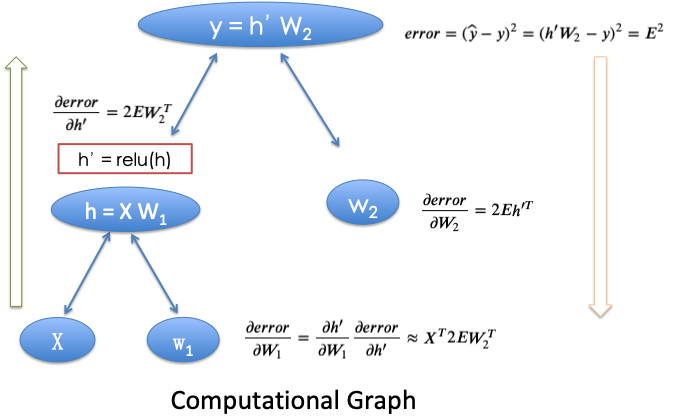

https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-tensors

```
learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)
    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)
    # Backprop to compute gradients 
    # of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
```

In [42]:
# Test
TestData=digits.data[-(L-l):]
PredictData=np.maximum(TestData.dot(w1),0).dot(w2)
compare=np.argmax(PredictData,axis=1)-digits.target[-(L-l):]
Accuracy=list(compare).count(0)/float(len(compare))
Accuracy

0.9333333333333333

## Recognizing Hand-Written Digits Using Pytorch

1. Using relu for only one time
2. learning rate = 0.1 
3. choose to use MSELoss 
4. Convert y_batch from the form of [1] to the form of [0,1,0, 0, 0, 0, 0, 0, 0, 0]

In [213]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim, from_numpy
import numpy as np

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                train_size = 0.9, test_size = 0.1, random_state=1)

Xtrain = torch.tensor(Xtrain, dtype = torch.float32)
ytrain = torch.tensor(ytrain, dtype = torch.int64)
Xtest = torch.tensor(Xtest, dtype = torch.float32)
ytest = torch.tensor(ytest, dtype = torch.int64)


batch_size = 100
train = torch.utils.data.TensorDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)
test = torch.utils.data.TensorDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                           batch_size=batch_size,
                                           shuffle=True)

In [215]:
from torch.nn import functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(64, 50)
        self.l2 = nn.Linear(50, 10)
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.l2(out)
        y_pred = F.softmax(out, dim = -1)
        return y_pred

# our model
model = Model()
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=1e-1) # learning rate is very sensitive

In [214]:
def get_prob(y_batch):
    y = np.zeros((len(y_batch), 10))
    y[np.arange(len(y_batch)), list(y_batch)] = 1
    y = torch.tensor(y, dtype = torch.float32)
    return y

In [216]:
# Training loop
num_epoch = 100
for k, epoch in enumerate(range(num_epoch)):
    for x_batch, y_batch in train_loader:
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_batch)  
        y_batch = get_prob(y_batch)
        # Compute and print loss
        loss = criterion(y_pred, y_batch)
        #loss = criterion(torch.max(y_pred, 1)[1], y_batch)
        if k % 100 ==0:
            print(f'Epoch: {epoch}/num_epoch | Loss: {loss.item():.4f}')
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch: 0/num_epoch | Loss: 0.0959
Epoch: 0/num_epoch | Loss: 0.0992
Epoch: 0/num_epoch | Loss: 0.0986
Epoch: 0/num_epoch | Loss: 0.0944
Epoch: 0/num_epoch | Loss: 0.0907
Epoch: 0/num_epoch | Loss: 0.0948
Epoch: 0/num_epoch | Loss: 0.0895
Epoch: 0/num_epoch | Loss: 0.0934
Epoch: 0/num_epoch | Loss: 0.0907
Epoch: 0/num_epoch | Loss: 0.0876
Epoch: 0/num_epoch | Loss: 0.0907
Epoch: 0/num_epoch | Loss: 0.0856
Epoch: 0/num_epoch | Loss: 0.0893
Epoch: 0/num_epoch | Loss: 0.0868
Epoch: 0/num_epoch | Loss: 0.0833
Epoch: 0/num_epoch | Loss: 0.0864
Epoch: 0/num_epoch | Loss: 0.0729


<div>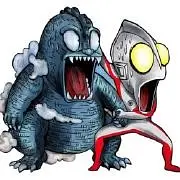</div>

<font size = 25>Model Validation</font>

In [217]:
# Test the Model
model.eval()  # Change model to 'eval' mode 
correct = 0
total = 0
for xval, yval in test_loader:
    outputs = model(xval)
    _, predicted = torch.max(outputs.data, 1)
    total += yval.size(0)
    correct += (predicted == yval).sum()

print('Test Accuracy: %d %%' % (100 * correct / total))

Test Accuracy: 98 %


# Recognizing Hand-Written Digits with CNN Using Pytorch

In [263]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim, from_numpy
import numpy as np

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                train_size = 0.9, test_size = 0.1, random_state=1)
# reshape the vector of length 64 to a matrix of 8*8
Xtrain = [i.reshape(8, 8) for i in Xtrain]
Xtest  = [i.reshape(8, 8) for i in Xtest]

Xtrain = torch.tensor(Xtrain, dtype = torch.float32)
ytrain = torch.tensor(ytrain, dtype = torch.int64)
Xtest = torch.tensor(Xtest, dtype = torch.float32)
ytest = torch.tensor(ytest, dtype = torch.int64)

batch_size = 100
train = torch.utils.data.TensorDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)

test = torch.utils.data.TensorDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(dataset=test,
                                           batch_size=batch_size,
                                           shuffle=True)



In [264]:
Xtrain.shape

torch.Size([1617, 8, 8])

In [285]:
Xtest.shape

torch.Size([180, 8, 8])

In [266]:
Xtrain[0]

tensor([[ 0.,  0.,  2., 13., 16., 16.,  7.,  0.],
        [ 0.,  0., 12., 15., 12., 16., 10.,  0.],
        [ 0.,  0., 16.,  9.,  0., 14.,  6.,  0.],
        [ 0.,  0.,  3.,  0.,  4., 16.,  1.,  0.],
        [ 0.,  0.,  0., 10., 14., 16.,  6.,  0.],
        [ 0.,  0.,  3., 16., 16., 11.,  2.,  0.],
        [ 0.,  0.,  0.,  9., 14.,  0.,  0.,  0.],
        [ 0.,  0.,  2., 15.,  6.,  0.,  0.,  0.]])

In [286]:
Xtest[0]

tensor([[ 0.,  0.,  6., 16., 11.,  0.,  0.,  0.],
        [ 0.,  0.,  9., 16., 16.,  5.,  0.,  0.],
        [ 0.,  0.,  8., 16., 16.,  4.,  0.,  0.],
        [ 0.,  0., 10., 16., 13.,  0.,  0.,  0.],
        [ 0.,  0., 13., 16., 12.,  0.,  0.,  0.],
        [ 0.,  0., 10., 16.,  9.,  0.,  0.,  0.],
        [ 0.,  0.,  9., 16., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  4., 15., 16.,  3.,  0.,  0.]])

In [267]:
# CNN Model (2 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=2), # in_channels = 1, out_channels = 32, kernel_size= 3
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(3*3*64, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = CNN()
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-1)

In [280]:
# Train the Model
from torch.autograd import Variable

num_epoch = 5
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):
        # reshape the shape of data
        images = images.view(len(images), 1, 8, 8)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epoch, i+1, len(train)//batch_size, loss.data.item()))


Epoch [1/5], Iter [1/16] Loss: 0.0766
Epoch [1/5], Iter [2/16] Loss: 0.1281
Epoch [1/5], Iter [3/16] Loss: 0.1132
Epoch [1/5], Iter [4/16] Loss: 0.0562
Epoch [1/5], Iter [5/16] Loss: 0.1689
Epoch [1/5], Iter [6/16] Loss: 0.0223
Epoch [1/5], Iter [7/16] Loss: 0.0726
Epoch [1/5], Iter [8/16] Loss: 0.0336
Epoch [1/5], Iter [9/16] Loss: 0.1128
Epoch [1/5], Iter [10/16] Loss: 0.0445
Epoch [1/5], Iter [11/16] Loss: 0.1064
Epoch [1/5], Iter [12/16] Loss: 0.0843
Epoch [1/5], Iter [13/16] Loss: 0.1876
Epoch [1/5], Iter [14/16] Loss: 0.0871
Epoch [1/5], Iter [15/16] Loss: 0.0484
Epoch [1/5], Iter [16/16] Loss: 0.0237
Epoch [1/5], Iter [17/16] Loss: 0.0027
Epoch [2/5], Iter [1/16] Loss: 0.0637
Epoch [2/5], Iter [2/16] Loss: 0.0636
Epoch [2/5], Iter [3/16] Loss: 0.0870
Epoch [2/5], Iter [4/16] Loss: 0.0358
Epoch [2/5], Iter [5/16] Loss: 0.0563
Epoch [2/5], Iter [6/16] Loss: 0.0901
Epoch [2/5], Iter [7/16] Loss: 0.0532
Epoch [2/5], Iter [8/16] Loss: 0.0934
Epoch [2/5], Iter [9/16] Loss: 0.0656
Epoc

In [287]:
# Test the Model
model.eval()  # Change model to 'eval' mode 
correct = 0
total = 0
for xval, yval in test_loader:
    # reshape the shape of data
    xval = xval.view(len(xval), 1, 8, 8)
    outputs = cnn(xval)
    _, predicted = torch.max(outputs.data, 1)
    total += yval.size(0)
    correct += (predicted == yval).sum()

print('Test Accuracy: %d %%' % (100 * correct / total))

Test Accuracy: 98 %


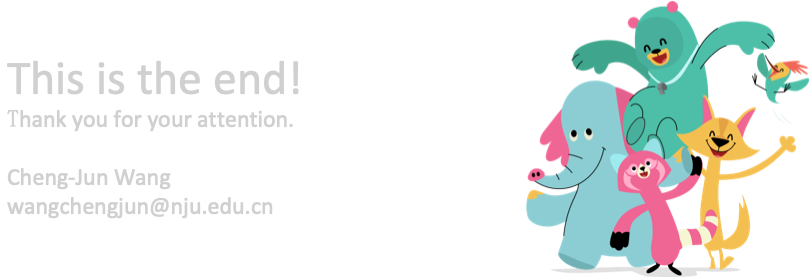